In [1]:
import requests
from requests.auth import HTTPBasicAuth
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import operator
import numpy as np
%matplotlib inline

auth = open("auth.txt").read()
user, pw = auth.split()[0], auth.split()[1]

## Links
https://stackoverflow.com/questions/10625190/most-suitable-python-library-for-github-api-v3 - PyGithub  
https://stackoverflow.com/questions/42801033/how-to-make-an-url-with-get-repos-owner-repo-labels-name - how to make url from Github GET request
https://stackoverflow.com/questions/43259946/github-api-getting-topics-of-a-github-repository - getting topics  
http://docs.python-requests.org/en/master/user/advanced/ - headers  
http://docs.python-requests.org/en/master/user/authentication/ - Requests Authentication   
https://github.com/nelsonic/github-scraper - go to "Interesting Facts"  
https://developer.github.com/v3/#pagination - need to access multiple pages

https://developer.github.com/v3/repos/#get - github API get request  
https://developer.github.com/v3/search/#search-topics - Github search repos by topic   
https://developer.github.com/v3/guides/traversing-with-pagination/ - Github pagination   
https://stackoverflow.com/questions/33878019/how-to-get-data-from-all-pages-in-github-api-with-python - pagination get next page
https://stackoverflow.com/questions/48390046/download-github-repositories-list-matching-a-topic - search github repos containing a specific topic  

## First, scrape list of github repos with the following topics

In [113]:
topics = ['collision']
max_requests = 4000

n_scraped = 0
for t in topics:
    link = 'https://api.github.com/search/repositories?q=topic:%s&per_page=100'%t
    f = open('repos/%s_repos.txt'%t, 'w')
    while link:
        r = requests.get(link, 
                     headers={"Accept":"application/vnd.github.mercy-preview+json"},
                     auth=HTTPBasicAuth(user, pw))
        if(r.ok):
            repos = json.loads(r.text or r.content)
            for item in repos['items']:
                f.write('%s\n'%item['url'])                
                n_scraped += 1 # number of repo urls scraped
        try:
            r_ = r.json()
            link = r.links['next']['url'] # get next page
            print(link)
        except:
            break

        if n_scraped >= max_requests:
            break
    
    f.close()
    print("Scraped %d repos for topic:'%s'"%(n_scraped, t))  # why is it only scraping 4x fewer than I want?

Scraped 86 repos for topic:'collision'


# Features:
- Topics
- Languages
- Popularity info - https://github.com/timqian/star-history - github star history  
- Lines of code - https://codetabs.com/count-loc/count-loc-online.html

In [115]:
topics = ['machine-learning']

for t in topics:
    repo_url_list = open('repos/%s_repos.txt'%t, 'r').read().splitlines() 
    data = {}
    for i, repo_url in enumerate(repo_url_list):
        try:
            r = requests.get(repo_url, 
                             headers={"Accept":"application/vnd.github.mercy-preview+json"},
                             auth=HTTPBasicAuth(user, pw))
            repoItem = json.loads(r.text or r.content)
            data[i] = {'topics': repoItem['topics'],
                       'language': repoItem['language'],
                       'stargazers': repoItem['stargazers_count'],
                       'watchers_count': repoItem['watchers_count'],
                       'forks_count': repoItem['forks_count'],
                       'url': repo_url}
        except:
            print('couldnt process github link %s'%repo_url)
    
    df = pd.DataFrame(data).T
    df.to_csv('repos/%s_data.csv'%t)

# Now, make some pretty plots
### Topics

In [25]:
df = pd.read_csv('repos/machine-learning_data.csv') 

# need to make dtype of list be list
                 #dtype={'forks_count': np.int32, 'stargazers': np.int32, 'watchers_count': np.int32,
                 #      'language': 'str', 'url':'str', 'topics':'list'})
df.head()

,Unnamed: 0,forks_count,language,stargazers,topics,url,watchers_count
0,0,64002,C++,102092,"['deep-learning', 'deep-neural-networks', 'dis...",https://api.github.com/repos/tensorflow/tensor...,102092
1,1,11331,Python,30273,"['data-science', 'deep-learning', 'machine-lea...",https://api.github.com/repos/keras-team/keras,30273
2,2,14206,Python,28627,"['data-analysis', 'data-science', 'machine-lea...",https://api.github.com/repos/scikit-learn/scik...,28627
3,3,14940,C++,24409,"['deep-learning', 'machine-learning', 'vision']",https://api.github.com/repos/BVLC/caffe,24409
4,4,8338,Jupyter Notebook,22789,"['deep-learning', 'examples', 'machine-learnin...",https://api.github.com/repos/aymericdamien/Ten...,22789


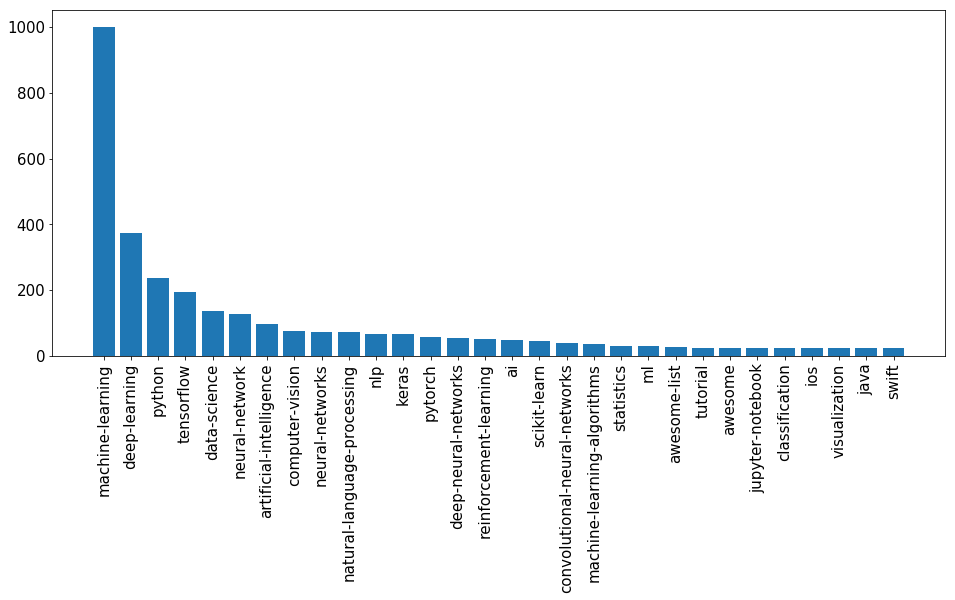

In [37]:
import ast  #temporary

topics = {}
for index, row in df.iterrows():
    for t in ast.literal_eval(row['topics']):
        if t in topics.keys():
            topics[t] += 1
        else:
            topics[t] = 1
            
topics_sorted = sorted(topics.items(), key=operator.itemgetter(1), reverse=True)[0:30]

fontsize=15

x, y = list(zip(*topics_sorted))
plt.figure(figsize=(16,10))
plt.bar(range(len(y)), y, align='center');
plt.xticks(range(len(y)), x, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.gcf().subplots_adjust(bottom=0.40)
plt.savefig('images/topics.png')

### Language

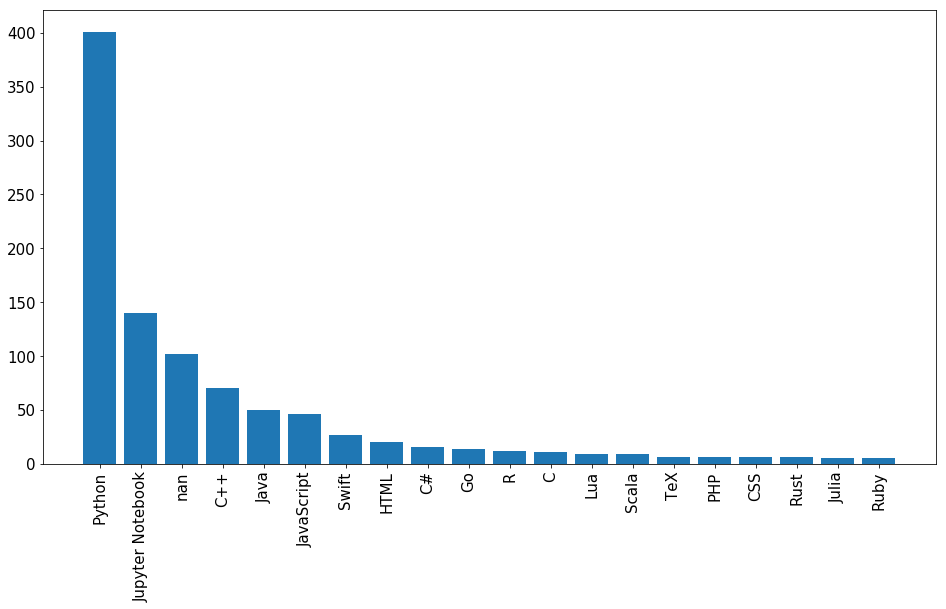

In [40]:
language = {}
for l in df['language'].unique():
    language[l] = 0

for index, row in df.iterrows():
    language[row['language']] += 1
            
language_sorted = sorted(language.items(), key=operator.itemgetter(1), reverse=True)[0:20]

x, y = list(zip(*language_sorted))
plt.figure(figsize=(16,10))
plt.bar(range(len(y)), y, align='center');
plt.xticks(range(len(y)), x, rotation=90, fontsize=fontsize);
plt.yticks(fontsize=fontsize);
plt.gcf().subplots_adjust(bottom=0.25);
plt.savefig('images/language.png')

## Stargazers

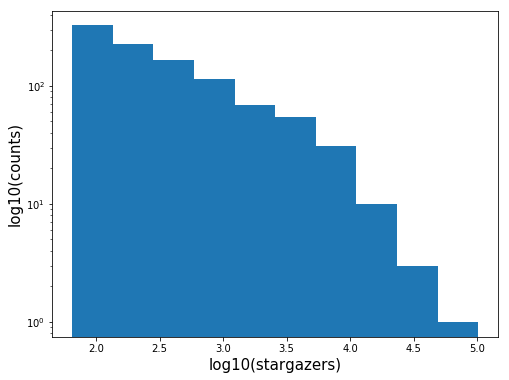

In [43]:
plt.figure(figsize=(8,6))
plt.hist(np.log10(df['stargazers'].values.astype('float')));
plt.yscale('log');
plt.xlabel('log10(stargazers)', fontsize=fontsize);
plt.ylabel('log10(counts)', fontsize=fontsize);
plt.savefig('images/stargazers.png')

## Extra code

In [75]:
# Multiple combined topics filter only repos that contain BOTH. 
# You thus instead want to run separate API calls for each topic separately. 
topics = ['machine-learning', 'astronomy']

req = 'https://api.github.com/search/repositories?q='
for i, t in enumerate(topics):
    req += 'topic:%s'%t
    if i < len(topics) - 1:
        req += '+'

print(req)   

https://api.github.com/search/repositories?q=topic:astronomy+topic:machine-learning


In [9]:
token = "b862b2561c460ac118c0c5ea98b28bfbf7b9517e"

In [26]:
git = Github(token)
user = git.get_user()
org = user.get_repo("django")
teams = org.get_teams()
team = [t for t in teams if t.name == 'TeamName'][0]  # assumes a match
print([m.login for m in team.get_members()])

UnknownObjectException: 404 {'message': 'Not Found', 'documentation_url': 'https://developer.github.com/v3/repos/#get'}

In [13]:
import argparse
def setup():
    parser = argparse.ArgumentParser()
    parser.add_argument("-o", "--org", help="django", required=True)
    parser.add_argument("-t", "--token", help="b862b2561c460ac118c0c5ea98b28bfbf7b9517e", required=True)
    args = parser.parse_args()
    return args

In [14]:
args = setup()
organization = args.org
authToken = args.token
g = Github(authToken)

usage: ipykernel_launcher.py [-h] -o ORG -t TOKEN
ipykernel_launcher.py: error: the following arguments are required: -o/--org, -t/--token


SystemExit: 2

/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
from github import Github
g = Github(base_url="https://silburt/api/v3", login_or_token="ba5cacf144b3907357f8d626b67708bd4a961540")

In [7]:
for repo in g.get_user().get_repos():
    print(repo.name)

ConnectionRefusedError: [Errno 61] Connection refused

In [8]:
from github_token import GITHUB_TOKEN, user, password

ModuleNotFoundError: No module named 'github_token'